In [ ]:
#!pip install seaborn
#!pip install matplotlib
#!pip install plotly==4.6.0
#!pip install sklearn
#!pip install wordcloud

In [70]:
import numpy as np
import pandas as pd 
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re

In [71]:
import plotly.express as px

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.read.format("csv").option("excape", "\"").option("header",True).load("s3://msbx5420-2020/team_castle_peak/news_cleaned.csv/")
df.show(5)

+---+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|_c0|             authors|               title|  publish_timestamp|         description|                text|                 url|        title_length|  description_length|         text_length|                data|                time|
+---+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  1|        ['Cbc News']|Coronavirus a 'wa...|2020-03-27 08:00:00|Canadian pharmaci...|"Canadian pharmac...|"" he said.  Tadr...| who get theirs f...| most of that sup...|                Ont.| has long warned ...|  including nearly 2|
|  2|        ['Cbc News']|Yukon gov't names...|2020-03-2

In [74]:
df.publish_timestamp = pd.to_datetime(df.publish_timestamp)

In [75]:
df["publish_year"] = df.publish_timestamp.dt.year

In [76]:
df["publish_month"] = df.publish_timestamp.dt.month

In [60]:
df_Jan = df[df.publish_month == 1]

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2817 entries, 0 to 2816
Data columns (total 13 columns):
authors               2817 non-null object
title                 2817 non-null object
publish_timestamp     2817 non-null datetime64[ns]
description           2817 non-null object
text                  2817 non-null object
url                   2817 non-null object
title_length          2817 non-null int64
description_length    2817 non-null int64
text_length           2817 non-null int64
data                  2817 non-null object
time                  2817 non-null object
publish_year          2817 non-null int64
publish_month         2817 non-null int64
dtypes: datetime64[ns](1), int64(5), object(7)
memory usage: 286.2+ KB


In [78]:
df.publish_year.value_counts()

2020    2786
2013      15
2014       6
2012       5
2004       2
2019       1
2015       1
2006       1
Name: publish_year, dtype: int64

In [79]:
df.data.value_counts()

2020-03-18    172
2020-03-20    165
2020-03-25    164
2020-03-19    159
2020-03-24    154
2020-03-26    154
2020-03-17    153
2020-03-23    147
2020-03-13    125
2020-03-16    112
2020-03-12     92
2020-03-21     88
2020-03-14     77
2020-03-22     68
2020-03-11     61
2020-03-10     61
2020-03-15     61
2020-03-27     39
2020-03-05     39
2020-03-06     37
2020-03-09     33
2020-03-04     32
2020-03-03     31
2020-03-07     25
2020-03-08     24
2020-02-06     21
2020-01-31     20
2020-02-29     20
2020-01-30     18
2020-02-04     18
             ... 
2020-01-17      1
2014-02-17      1
2004-01-16      1
2020-01-09      1
2020-01-13      1
2015-12-23      1
2012-11-30      1
2013-02-19      1
2012-09-23      1
2013-06-17      1
2020-01-12      1
2020-01-08      1
2013-02-25      1
2013-07-09      1
2014-01-28      1
2013-07-05      1
2014-04-29      1
2013-06-04      1
2020-01-14      1
2014-04-20      1
2004-01-31      1
2013-06-20      1
2013-05-31      1
2012-12-11      1
2012-11-24

Text(0.5, 1.0, 'Plot by Data')

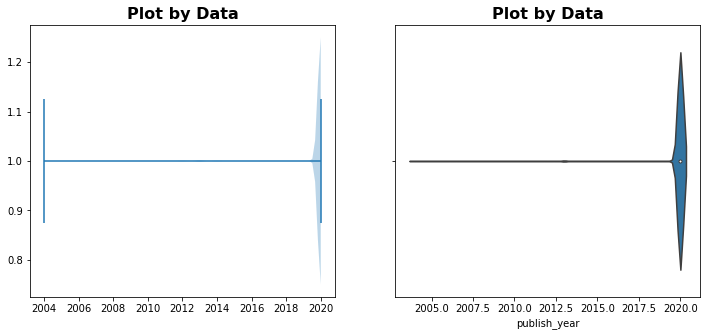

In [80]:
fig, axes = plt.subplots(1,2,figsize=(12, 5))
axes[0].violinplot(df.publish_year,vert=False)
axes[0].set_title('Plot by Data', fontsize=16,fontweight='bold',color='black')
s=sns.violinplot(df.publish_year,ax=axes[1])
s.set_title("Plot by Data",fontsize=16,fontweight='bold')

Text(0.5, 1.0, 'Plot by Data')

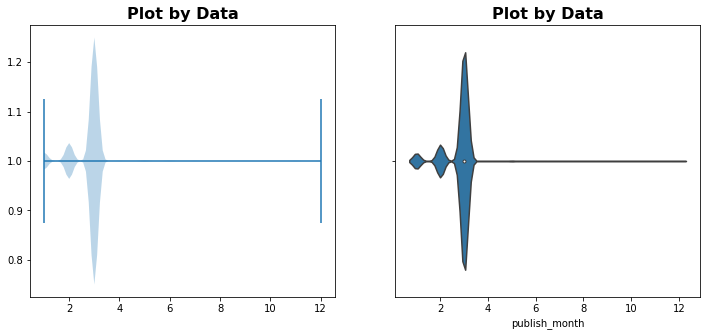

In [81]:
fig, axes = plt.subplots(1,2,figsize=(12, 5))
axes[0].violinplot(df.publish_month,vert=False)
axes[0].set_title('Plot by Data', fontsize=16,fontweight='bold',color='black')
s=sns.violinplot(df.publish_month,ax=axes[1])
s.set_title("Plot by Data",fontsize=16,fontweight='bold')

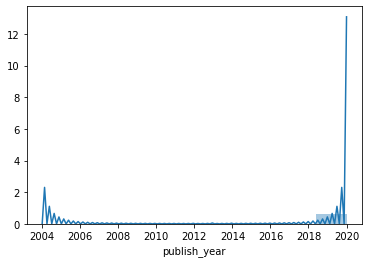

In [82]:
sns.distplot(df.publish_year, bins=10)

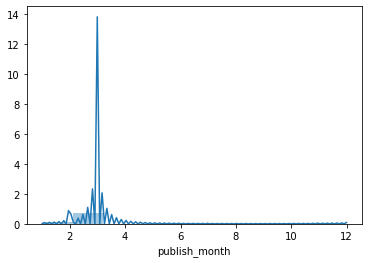

In [83]:
sns.distplot(df.publish_month, bins=10)

In [84]:
df_2020 = df[df.publish_year == 2020]

In [85]:
df_2020[["title_length","description_length","text_length"]].describe()

,title_length,description_length,text_length
count,2786.000000,2786.000000,2786.000000
mean,73.777459,180.664393,4500.496770
std,14.956574,56.963704,2947.893081
min,29.000000,38.000000,96.000000
25%,63.000000,140.000000,2701.250000
50%,74.000000,175.000000,3972.000000
75%,84.000000,216.000000,5597.000000
max,110.000000,515.000000,32762.000000


In [86]:
df_2020_text_length = df_2020.groupby("data")["text_length"].mean().reset_index()

In [87]:
lr = LinearRegression()
lr.fit(df_2020_text_length.index.values.reshape(-1,1), df_2020_text_length.text_length.values.reshape(-1,1) )
predictedLine = lr.predict(df_2020_text_length.index.values.reshape(-1,1))

In [88]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                x=df_2020_text_length.data,
                y=df_2020_text_length.text_length,
                name="text_length",
                line_color='black',
                opacity=0.8))

fig.add_trace(go.Scatter(
                x=df_2020_text_length.data,
                y=predictedLine.flatten(),
                name="Trend line",
                line_color='red',
                opacity=0.8))

# Use date string to set xaxis range
fig.layout.update(title_text="Trend on the length of the articles", yaxis_title="word count")
fig.show()

In [90]:
usecase_specific_words = ["good","morning","said","says","news", "will","monday","tuesday","wednesday","thursday","friday","saturday","sunday"]
print("Total extra stopwords : ",len([STOPWORDS.add(word) for word in usecase_specific_words]))
stopwords = set(STOPWORDS)

Total extra stopwords :  13


In [91]:
df_2020["text"] = df_2020.text.apply(lambda x : x.lower())

C:\Users\zhe zhao\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [92]:
def word_cloud(month_no, month):
    words_list = df_2020[df_2020.publish_timestamp.dt.month.astype(int) == month_no].text.values.tolist()
    words = " ".join([ re.sub(r"[^a-zA-Z0-9]+", ' ', word.strip()).strip()  for word in " ".join(words_list).split(" ") ]).split(" ")
    wordcloud = WordCloud(
                        background_color='white',
                        stopwords=stopwords,
                        max_font_size=40, 
                        random_state=37,
                        max_words=200
                     ).generate(" ".join(words))
    print(month+" - Total number of words - "+str(len(words)))
    plt.figure(figsize=(14,15))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    

January - Total number of words - 117666


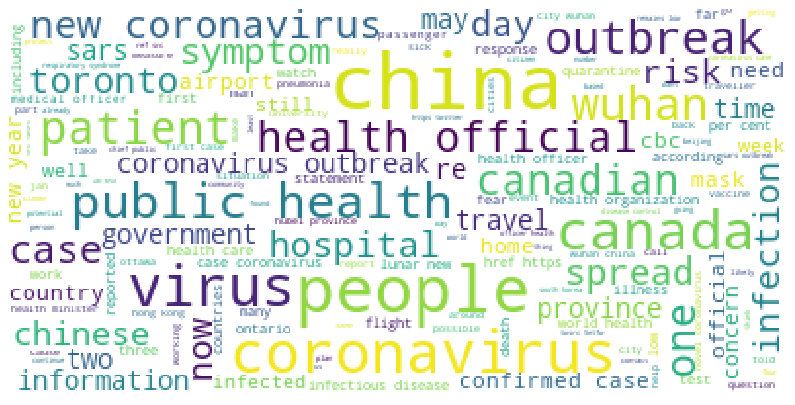

In [93]:
 word_cloud(1, "January")

February - Total number of words - 279131


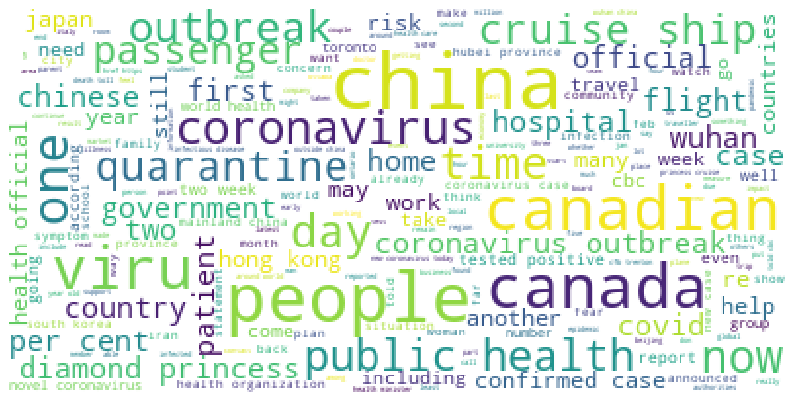

In [94]:
word_cloud(2, "February")

March - Total number of words - 1731510


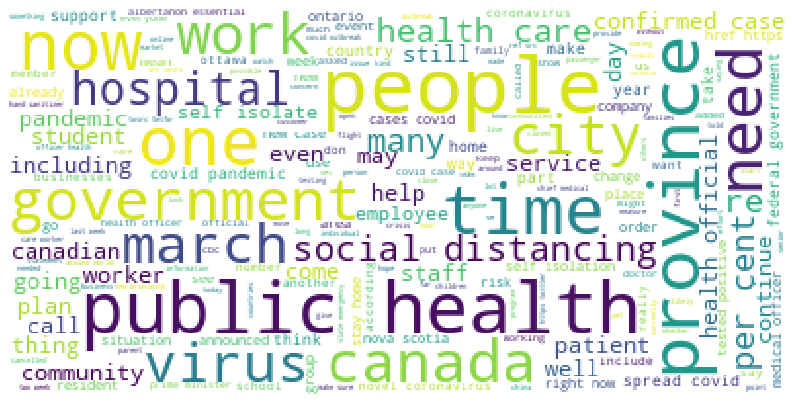

In [95]:
word_cloud(3, "March")